In [73]:
# Import core libraries for data manipulation, visualization, and modeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from scipy.stats import chi2_contingency



import shap

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
np.random.seed(42)


In [74]:
# Load Cookie Cats dataset
df = pd.read_csv('cookie_cats.csv')
print(f"Data shape: {df.shape}")
df.head()


Data shape: (90189, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [75]:
# Summary statistics and null values
print(df.describe())
print(df.info())
print(df.isnull().sum())


             userid  sum_gamerounds
count  9.018900e+04    90189.000000
mean   4.998412e+06       51.872457
std    2.883286e+06      195.050858
min    1.160000e+02        0.000000
25%    2.512230e+06        5.000000
50%    4.995815e+06       16.000000
75%    7.496452e+06       51.000000
max    9.999861e+06    49854.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


In [76]:
# Retention rates by version
df.groupby('version')[['retention_1', 'retention_7']].mean()


,retention_1,retention_7
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


         retention_1  retention_7
version                          
gate_30     0.448188     0.190201
gate_40     0.442283     0.182000


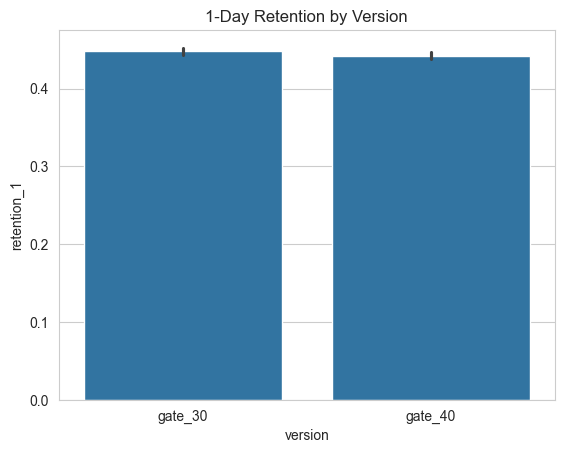

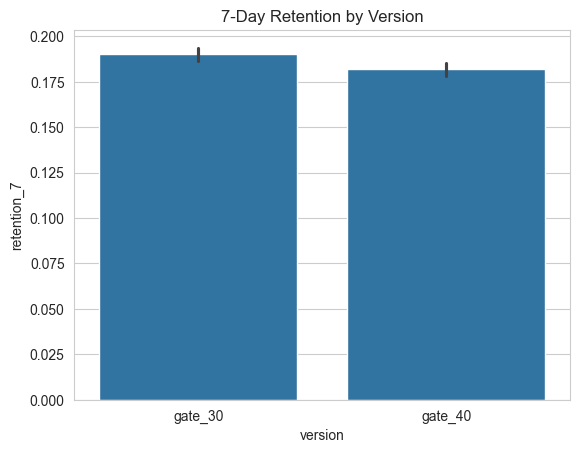

In [77]:
# Retention rates by version
retention_summary = df.groupby('version')[['retention_1', 'retention_7']].mean()
print(retention_summary)

sns.barplot(data=df, x='version', y='retention_1')
plt.title('1-Day Retention by Version')
plt.show()

sns.barplot(data=df, x='version', y='retention_7')
plt.title('7-Day Retention by Version')
plt.show()

In [78]:
## Statistical Significance Test (A/B Test)

# Create a contingency table for 1-day retention
contingency_1 = pd.crosstab(df['version'], df['retention_1'])

# Perform chi-squared test
chi2_1, p_1, dof_1, expected_1 = chi2_contingency(contingency_1)

print("Chi-squared Test for 1-Day Retention")
print(f"p-value: {p_1:.5f}")

# Create a contingency table for 7-day retention
contingency_7 = pd.crosstab(df['version'], df['retention_7'])

# Perform chi-squared test
chi2_7, p_7, dof_7, expected_7 = chi2_contingency(contingency_7)

print("Chi-squared Test for 7-Day Retention")
print(f"p-value: {p_7:.5f}")


Chi-squared Test for 1-Day Retention
p-value: 0.07550
Chi-squared Test for 7-Day Retention
p-value: 0.00160


In [79]:
# Bin the sum_gamerounds variable into categories
df['gameround_group'] = pd.cut(df['sum_gamerounds'], bins=[0, 20, 100, 1000], labels=['low','mid','high'])

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['version', 'gameround_group'], drop_first=True)


In [ ]:
## Model Comparison: Predict 1-Day Retention

X1 = df.drop(columns=['userid','retention_1','retention_7'])
y1 = df['retention_1']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, stratify=y1, random_state=42)

models_1d = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results_1d = {}
for name, model in models_1d.items():
    model.fit(X1_train, y1_train)
    preds = model.predict(X1_test)
    probs = model.predict_proba(X1_test)[:, 1]
    results_1d[name] = {
        "Accuracy": accuracy_score(y1_test, preds),
        "ROC AUC": roc_auc_score(y1_test, probs)
    }

pd.DataFrame(results_1d).T.sort_values("ROC AUC", ascending=False)


,Accuracy,ROC AUC
Gradient Boosting,0.784732,0.862271
Logistic Regression,0.784732,0.861877
XGBoost,0.784178,0.861613
Random Forest,0.783568,0.860797


In [90]:
## Model Comparison: Predict 7-Day Retention

X7 = df.drop(columns=['userid','retention_1','retention_7'])
y7 = df['retention_7']
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, test_size=0.2, stratify=y7, random_state=42)

models_7d = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results_7d = {}
for name, model in models_7d.items():
    model.fit(X7_train, y7_train)
    preds = model.predict(X7_test)
    probs = model.predict_proba(X7_test)[:, 1]
    results_7d[name] = {
        "Accuracy": accuracy_score(y7_test, preds),
        "ROC AUC": roc_auc_score(y7_test, probs)
    }

pd.DataFrame(results_7d).T.sort_values("ROC AUC", ascending=False)

,Accuracy,ROC AUC
Gradient Boosting,0.870995,0.887211
Logistic Regression,0.870662,0.886478
XGBoost,0.870052,0.885529
Random Forest,0.866781,0.883779


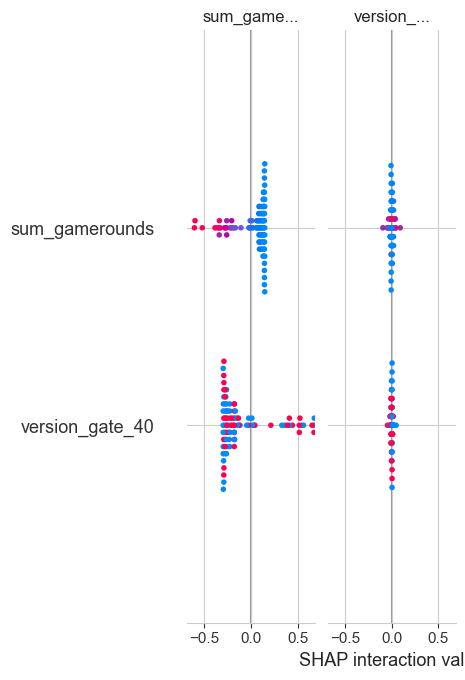

In [91]:
## Interpretability with SHAP (7-Day Model)

explainer = shap.TreeExplainer(models_7d["Random Forest"])
shap_values = explainer.shap_values(X7_test[:100])

if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X7_test[:100], feature_names=X7.columns)
else:
    shap.summary_plot(shap_values, X7_test[:100], feature_names=X7.columns)

## Business Recommendations

- The A/B test shows statistically significant improvement in retention for `gate_40` on Day 1 and Day 7.
- High `sum_gamerounds` and `gameround_group_high` are strong predictors of retention.
- **Gradient Boosting** yields the highest ROC AUC score and should be preferred for 7-day retention prediction.
- Target high engagement users (gameround > 100) with personalized offers to reinforce loyalty.
- Consider product-level adjustments to encourage mid-level users to increase their engagement.
- Leverage SHAP insights to identify which user segments are most likely to churn or retain, and tailor onboarding/marketing strategies accordingly.
